# Method - 2 

Link to data : https://physionet.org/content/ptbdb/1.0.0/ OR https://www.kaggle.com/datasets/shayanfazeli/heartbeat
# Autoencoder based CNN Classifier

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [3]:
normal = pd.read_csv('ptbdb_normal.csv')
abnormal = pd.read_csv('ptbdb_abnormal.csv')

In [32]:
CLASS_NAMES = ["1", "0"]
normal = normal.set_axis(range(1,189), axis =1)
abnormal = abnormal.set_axis(range(1,189), axis =1)
normal = normal.assign(target = CLASS_NAMES[0])
abnormal = abnormal.assign(target = CLASS_NAMES[1])

In [33]:
data = pd.concat([normal, abnormal])

In [34]:
data

1         2         3         4         5         6         7  \
0      1.000000  0.794681  0.375387  0.116883  0.000000  0.171923  0.283859   
1      0.909029  0.791482  0.423169  0.186712  0.000000  0.007836  0.063032   
2      1.000000  0.478893  0.056760  0.064176  0.081289  0.072732  0.055619   
3      1.000000  0.867238  0.201360  0.099349  0.141336  0.120934  0.108516   
4      0.948983  0.505265  0.004176  0.022513  0.059550  0.107298  0.110385   
...         ...       ...       ...       ...       ...       ...       ...   
10500  0.981409  1.000000  0.559171  0.287093  0.196639  0.204862  0.215946   
10501  0.906250  0.922379  0.878024  0.810484  0.712702  0.667339  0.608871   
10502  1.000000  0.867971  0.674122  0.470332  0.296987  0.169307  0.077664   
10503  1.000000  0.984672  0.658888  0.556394  0.446809  0.395790  0.315260   
10504  0.997886  0.700317  0.464059  0.318182  0.233615  0.184989  0.124207   

              8         9        10  ...  180  181  182  183  184  185  186  \
0      0.293754  0.325912  0.345083  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.077002  0.074957  0.077342  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.048774  0.054478  0.041643  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.096393  0.093436  0.100828  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.111293  0.116558  0.118192  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
10500  0.243833  0.242760  0.250268  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10501  0.527218  0.480847  0.442540  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10502  0.081392  0.074868  0.089779  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10503  0.276367  0.261039  0.258522  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10504  0.082981  0.087738  0.063953  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       187  188  target  
0      0.0  0.0       1  
1      0.0  0.0       1  
2      0.0  0.0       1  
3      0.0  0.0       1  
4      0.0  0.0       1  
...    ...  ...     ...  
10500  0.0  1.0       0  
10501  0.0  1.0       0  
10502  0.0  1.0       0  
10503  0.0  1.0       0  
10504  0.0  1.0       0  

[14550 rows x 189 columns]

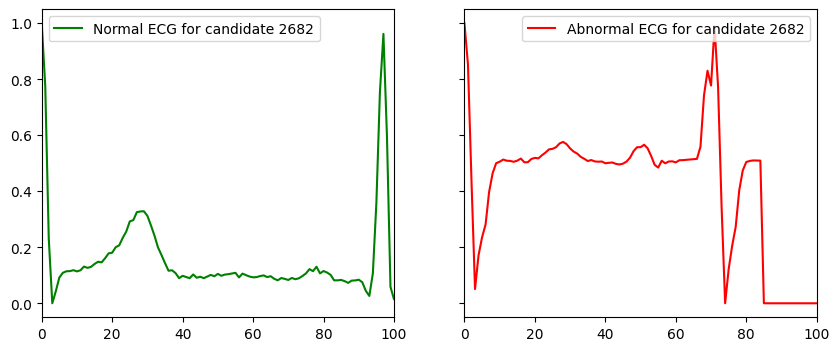

In [4]:
fig, ax = plt.subplots(1,2, figsize = (10,4), sharey = True)

index = np.random.randint(0,len(normal),2)
ax[0].plot(normal.iloc[index[0],:].values, label = f'Normal ECG for candidate {index[0]}', color = 'green')
ax[0].legend()
ax[0].set_xlim([0,100])
ax[1].plot(abnormal.iloc[index[0],:].values, label = f'Abnormal ECG for candidate {index[0]}', color = 'red')
ax[1].legend()
ax[1].set_xlim([0,100])
plt.show()

In [35]:
X = data.drop(columns='target').values
y = data['target'].values

In [36]:
X = torch.tensor(X)
y = np.array(y, dtype=int)
y = torch.tensor(y)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Convert data to float
X_train = X_train.float()
X_test = X_test.float()

# Create DataLoaders
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Building the Autoencoder

In [39]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Define the encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # 'padding=1' for 'same' padding
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
            # Add more layers as needed
        )
        # Define the decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
            
            # Add more layers as needed
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        #print("Input shape:", x.shape)
        x = self.encoder(x)
        #print("After encoder:", x.shape)
        x = self.decoder(x)
        #print("After decoder:", x.shape)
        return x

autoencoder = Autoencoder()

In [40]:
criterion = nn.MSELoss()  # Since it's reconstruction, mean squared error is a common choice
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
losses = []
num_epochs =50
for epoch in range(num_epochs):
    total_loss = 0.0
    batch_count = 0

    for inputs, _ in train_loader:
        inputs = inputs.float()
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1

    average_loss = total_loss / batch_count
    losses.append(average_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

c:\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64, 188])) that is different to the input size (torch.Size([64, 1, 188])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([56, 188])) that is different to the input size (torch.Size([56, 1, 188])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Loss: 0.0547
Epoch [2/50], Loss: 0.0481
Epoch [3/50], Loss: 0.0573
Epoch [4/50], Loss: 0.0471
Epoch [5/50], Loss: 0.0478
Epoch [6/50], Loss: 0.0625
Epoch [7/50], Loss: 0.0518
Epoch [8/50], Loss: 0.0586
Epoch [9/50], Loss: 0.0355
Epoch [10/50], Loss: 0.0421
Epoch [11/50], Loss: 0.0276
Epoch [12/50], Loss: 0.0369
Epoch [13/50], Loss: 0.0331
Epoch [14/50], Loss: 0.0346
Epoch [15/50], Loss: 0.0332
Epoch [16/50], Loss: 0.0254
Epoch [17/50], Loss: 0.0414
Epoch [18/50], Loss: 0.0274
Epoch [19/50], Loss: 0.0330
Epoch [20/50], Loss: 0.0322
Epoch [21/50], Loss: 0.0348
Epoch [22/50], Loss: 0.0373
Epoch [23/50], Loss: 0.0312
Epoch [24/50], Loss: 0.0342
Epoch [25/50], Loss: 0.0332
Epoch [26/50], Loss: 0.0334
Epoch [27/50], Loss: 0.0314
Epoch [28/50], Loss: 0.0309
Epoch [29/50], Loss: 0.0360
Epoch [30/50], Loss: 0.0289
Epoch [31/50], Loss: 0.0290
Epoch [32/50], Loss: 0.0285
Epoch [33/50], Loss: 0.0338
Epoch [34/50], Loss: 0.0282
Epoch [35/50], Loss: 0.0368
Epoch [36/50], Loss: 0.0347
E

In [41]:
# plt.figure(figsize=(8,16))
# plt.plot(num_epochs, losse

len(losses)

50

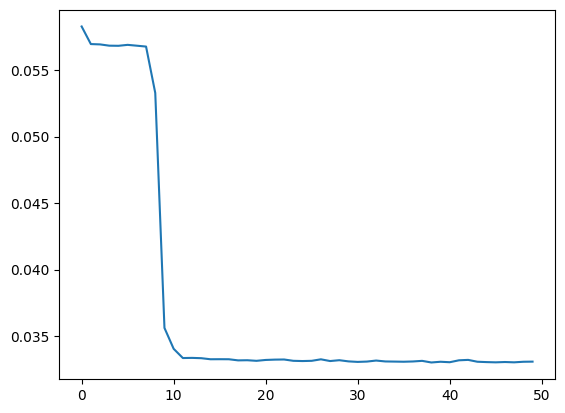

In [42]:
plt.plot(losses)

In [43]:
criterion = nn.MSELoss()
test_losses = []
num_epochs = 50

# No need for an optimizer here, as you're not training the model
for epoch in range(num_epochs):
    total_loss = 0.0
    batch_count = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, _ in test_loader:
            inputs = inputs.float()
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)

            total_loss += loss.item()
            batch_count += 1

    average_loss = total_loss / batch_count
    test_losses.append(average_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')


c:\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([30, 188])) that is different to the input size (torch.Size([30, 1, 188])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Average Loss: 0.0334
Epoch [2/50], Average Loss: 0.0334
Epoch [3/50], Average Loss: 0.0334
Epoch [4/50], Average Loss: 0.0334
Epoch [5/50], Average Loss: 0.0334
Epoch [6/50], Average Loss: 0.0334
Epoch [7/50], Average Loss: 0.0334
Epoch [8/50], Average Loss: 0.0334
Epoch [9/50], Average Loss: 0.0334
Epoch [10/50], Average Loss: 0.0334
Epoch [11/50], Average Loss: 0.0334
Epoch [12/50], Average Loss: 0.0334
Epoch [13/50], Average Loss: 0.0334
Epoch [14/50], Average Loss: 0.0334
Epoch [15/50], Average Loss: 0.0334
Epoch [16/50], Average Loss: 0.0334
Epoch [17/50], Average Loss: 0.0334
Epoch [18/50], Average Loss: 0.0334
Epoch [19/50], Average Loss: 0.0334
Epoch [20/50], Average Loss: 0.0334
Epoch [21/50], Average Loss: 0.0334
Epoch [22/50], Average Loss: 0.0334
Epoch [23/50], Average Loss: 0.0334
Epoch [24/50], Average Loss: 0.0334
Epoch [25/50], Average Loss: 0.0334
Epoch [26/50], Average Loss: 0.0334
Epoch [27/50], Average Loss: 0.0334
Epoch [28/50], Average Loss: 0.0334
E

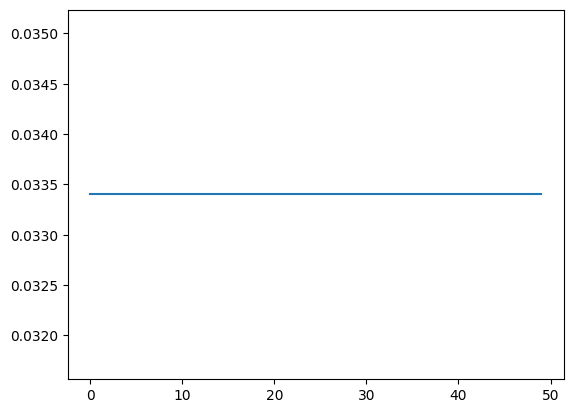

In [44]:
plt.plot(test_losses)

In [45]:
class CNNAutoencoderClassifier(nn.Module):
    def __init__(self):
        super(CNNAutoencoderClassifier, self).__init__()
        # Encoder (same as before)
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        # Classification layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (188 // 4), 1)  # Adjust the input size based on your data
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.encoder(x)
        x = self.classifier(x)
        return x




# Instantiate the model
model = CNNAutoencoderClassifier()

# Update the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


Classifeir Training

In [65]:
def init_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.1)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(init_weights)



criterion = nn.BCEWithLogitsLoss()  # Use appropriate loss function for your classification task
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0
    batch_count = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.float(), labels.float()  # Ensure correct data type
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)  # Adjust depending on your label shape
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1

        if epoch == 0 and batch_count == 1:  # Print outputs for the first batch of the first epoch
            print("Sample outputs:", outputs.squeeze()[:10])  # Print first 10 outputs
            print("Sample labels:", labels[:10])  # Print first 10 labels


    average_loss = total_loss / batch_count
    train_losses.append(average_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')


Sample outputs: tensor([-0.1524, -0.0735, -0.1914, -0.1860, -0.0157, -0.1648, -0.0763, -0.1662,
        -0.1653, -0.1606], grad_fn=<SliceBackward0>)
Sample labels: tensor([1., 1., 1., 1., 1., 0., 1., 0., 0., 0.])
Epoch [1/50], Average Loss: 0.7003
Epoch [2/50], Average Loss: 0.5908
Epoch [3/50], Average Loss: 0.5899
Epoch [4/50], Average Loss: 0.5897
Epoch [5/50], Average Loss: 0.5899
Epoch [6/50], Average Loss: 0.5906
Epoch [7/50], Average Loss: 0.5903
Epoch [8/50], Average Loss: 0.5896
Epoch [9/50], Average Loss: 0.5895
Epoch [10/50], Average Loss: 0.5899
Epoch [11/50], Average Loss: 0.5907
Epoch [12/50], Average Loss: 0.5902
Epoch [13/50], Average Loss: 0.5900
Epoch [14/50], Average Loss: 0.5900
Epoch [15/50], Average Loss: 0.5903
Epoch [16/50], Average Loss: 0.5908
Epoch [17/50], Average Loss: 0.5901
Epoch [18/50], Average Loss: 0.5906
Epoch [19/50], Average Loss: 0.5903
Epoch [20/50], Average Loss: 0.5909
Epoch [21/50], Average Loss: 0.5898
Epoch [22/50], Average Loss: 0.5905
Epoc

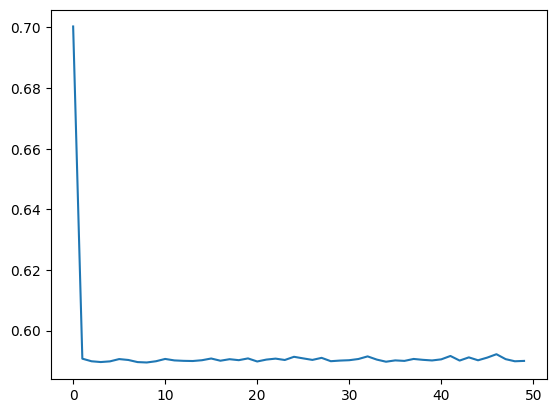

In [66]:
plt.plot(train_losses)

In [67]:
model.eval()  # Set the model to evaluation mode
test_losses = []
criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():  # Disable gradient calculations
    total_loss = 0.0
    batch_count = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.float(), labels.float()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        print(f'{batch_count} has loss {loss}')
        total_loss += loss.item()
        batch_count += 1

    average_loss = total_loss / batch_count
    test_losses.append(average_loss)
    print(f'Test Average Loss: {average_loss:.4f}')


0 has loss 0.5976111888885498
1 has loss 0.49200084805488586
2 has loss 0.6152129173278809
3 has loss 0.5976111888885498
4 has loss 0.5096026062965393
5 has loss 0.5272042751312256
6 has loss 0.6152129173278809
7 has loss 0.5800095200538635
8 has loss 0.6328145861625671
9 has loss 0.650416374206543
10 has loss 0.5272043347358704
11 has loss 0.6328146457672119
12 has loss 0.6504163146018982
13 has loss 0.49200087785720825
14 has loss 0.5624077916145325
15 has loss 0.4743991792201996
16 has loss 0.6152129173278809
17 has loss 0.6152129173278809
18 has loss 0.650416374206543
19 has loss 0.5800095200538635
20 has loss 0.5800094604492188
21 has loss 0.7032214999198914
22 has loss 0.474399209022522
23 has loss 0.6856198310852051
24 has loss 0.6856198310852051
25 has loss 0.5800095200538635
26 has loss 0.5976111888885498
27 has loss 0.7384248971939087
28 has loss 0.5800095200538635
29 has loss 0.5976111888885498
30 has loss 0.650416374206543
31 has loss 0.5624077916145325
32 has loss 0.562407

The Test Average Loss is 0.6047 which is extremely high and most probbaly needs a deeper CNN. From the analysis, use of Autoencoder in it's current state is not a good option. Using the complete CNN model is a better idea for more accurate predictions. 